.ipynb settings

In [2]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

In [3]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/

import useful_functions

Importation of the dataset(s)

In [4]:
#Importing dataset(s)
from data import make_dataset

#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00 = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00 = make_dataset.load_data(False, 'processed/split/Y_test_00')


#Load the not_split train and test datasets:
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# VI) <u> Pipeline development 

<span style="color:#FF1493;"> <strong> <font size="4">1) Logistic Regression Pipeline and GridSearchCV implementation

In [ ]:

# --------------------------------------------------------------
# Correlated features remover (not used)
# --------------------------------------------------------------

from features import features_selection
from configuration import constant_variables
from dvclive import Live


#Correlated features remover definition (it's a transformer)
corr_features_selector = features_selection.correlated_features_removal_transformer(corr_threshold = 0.95)


# --------------------------------------------------------------
# Features selector
# --------------------------------------------------------------

"""
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_sfs = LogisticRegression(max_iter=10000, C = 0.3, random_state =33, penalty = 'l2')
sequ_feat_selector = SFS(estimator = model_sfs, k_features = 'best', forward = True, verbose = 0, cv=constant_variables.CV, scoring = 'neg_log_loss', n_jobs = -1)
"""

#OU

#Filter features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_feat_selector = SelectKBest(f_classif, k= 10)

# --------------------------------------------------------------
# Scaler
# --------------------------------------------------------------

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()


# --------------------------------------------------------------
# Model
# --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l1', fit_intercept=True, random_state = 999, solver = 'saga', max_iter= 3000, verbose = False, tol=1e-4)

# --------------------------------------------------------------
# Pipeline
# --------------------------------------------------------------
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[("scaler",scaler), ("features_selector",filter_feat_selector), ("model", model)])


#parameters to optimize definition
import numpy as np
parameters = {'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
             'model__C': np.logspace(-3, 1, 21),
             'model__solver': ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs'],
             'features_selector__k' : [6,11,13,16]
             }

# --------------------------------------------------------------
# GridSearchCV
# --------------------------------------------------------------
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
from configuration import constant_variables

grid_search = GridSearchCV(pipeline, parameters, cv=constant_variables.CV, scoring = 'neg_log_loss', verbose=0)
# Fit the GridSearchCV to the data
grid_search.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:779: UserWarning: k=17 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:779: UserWarning: k=17 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:779: UserWarning: k=17 is greater than n_features=16. All the features will be returned.
  warnings.warn(
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:779: UserWarning: k=17 is 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('features_selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='l1',
                                                           random_state=999,
                                                           solver='saga',
                                                           verbose=False))]),
             param_grid={'features_selector__k': [6, 11, 13, 16, 17],
                         'model__C': array([1.00000000e-03...
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'model__solver': ['saga', 'sag', 'liblinear',
                                           'newton-cg', 'lbfgs']},
             scoring='neg_log_loss')

<span style="color:#FF1493;"> <strong> <font size="4">2) Neural Network Pipeline and GridSearchCV optimisation

In [ ]:

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2


def create_nn_model_NN(optimizer='adam', activation='relu', neurons=32, layers=2, regularizer=None, dropout_rate=0.0):
    model = Sequential()
    # On ne met PAS input_dim, scikeras va inférer tout seul
    model.add(Dense( activation=activation, kernel_regularizer=regularizer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

nn_wrapper = KerasClassifier(
    model=create_nn_model_NN,
    optimizer="adam",
    activation="relu",
    neurons=32,
    layers=2,
    regularizer=None,
    dropout_rate=0.0,
    verbose=0,
    # force scikeras à recréer un nouveau modèle *à chaque fit*
    # pour éviter le bug "no defined outputs yet"
    warm_start=False 
)

pipeline_NN = Pipeline([
    ("scaler", StandardScaler()),
    ("features_selector", SelectKBest(f_classif)),
    ("model", nn_wrapper)
])

parameters_NN = {
    'features_selector__k': [6, 11, 13, 16],
    'model__model__optimizer': ['adam', 'rmsprop'],
    'model__model__activation': ['relu', 'tanh'],
    'model__model__neurons': [16, 64],
    'model__model__layers': [2, 3],
    'model__model__regularizer': [None, l1(0.01), l2(0.01)],
    'model__model__dropout_rate': [0.0, 0.3]
}

grid_search_NN = GridSearchCV(
    pipeline_NN,
    parameters_NN,
    cv=3,
    scoring='neg_log_loss',
    verbose=1
)

grid_search_NN.fit(X_train_00, Y_train_00)

print("Best Parameters:", grid_search_NN.best_params_)
print("Best Score:", grid_search_NN.best_score_)


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet 

ValueError: 
All the 1152 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2304' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2305' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2306' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2307' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2308' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2309' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2310' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2311' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2312' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2313' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2314' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2315' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2316' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2317' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2318' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2319' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2320' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2321' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2322' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2323' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2324' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2325' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2326' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2327' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2328' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2329' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2330' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2331' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2332' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2333' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2334' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2335' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2336' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2337' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2338' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2339' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2340' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2341' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2342' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2343' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2344' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2345' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2346' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2347' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2348' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2349' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2350' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2351' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2352' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2353' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2354' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2355' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2356' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2357' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2358' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2359' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2360' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2361' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2362' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2363' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2364' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2365' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2366' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2367' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2368' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2369' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2370' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2371' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2372' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2373' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2374' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2375' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2376' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2377' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2378' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2379' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2380' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2381' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2382' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2383' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2384' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2385' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2386' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2387' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2388' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2389' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2390' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2391' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2392' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2393' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2394' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2395' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2396' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2397' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2398' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2399' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2400' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2401' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2402' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2403' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2404' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2405' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2406' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2407' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2408' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2409' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2410' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2411' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2412' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2413' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2414' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2415' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2416' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2417' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2418' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2419' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2420' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2421' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2422' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2423' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2424' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2425' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2426' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2427' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2428' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2429' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2430' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2431' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2432' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2433' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2434' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2435' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2436' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2437' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2438' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2439' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2440' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2441' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2442' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2443' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2444' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2445' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2446' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2447' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2448' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2449' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2450' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2451' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2452' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2453' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2454' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2455' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2456' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2457' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2458' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2459' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2460' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2461' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2462' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2463' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2464' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2465' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2466' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2467' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2468' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2469' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2470' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2471' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2472' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2473' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2474' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2475' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2476' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2477' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2478' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2479' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2480' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2481' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2482' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2483' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2484' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2485' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2486' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2487' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2488' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2489' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2490' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2491' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2492' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2493' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2494' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2495' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2496' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2497' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2498' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2499' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2500' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2501' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2502' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2503' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2504' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2505' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2506' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2507' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2508' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2509' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2510' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2511' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2512' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2513' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2514' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2515' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2516' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2517' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2518' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2519' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2520' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2521' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2522' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2523' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2524' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2525' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2526' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2527' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2528' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2529' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2530' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2531' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2532' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2533' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2534' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2535' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2536' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2537' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2538' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2539' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2540' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2541' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2542' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2543' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2544' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2545' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2546' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2547' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2548' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2549' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2550' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2551' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2552' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2553' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2554' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2555' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2556' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2557' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2558' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2559' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2560' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2561' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2562' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2563' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2564' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2565' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2566' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2567' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2568' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2569' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2570' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2571' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2572' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2573' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2574' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2575' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2576' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2577' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2578' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2579' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2580' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2581' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2582' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2583' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2584' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2585' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2586' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2587' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2588' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2589' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2590' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2591' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2592' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2593' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2594' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2595' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2596' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2597' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2598' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2599' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2600' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2601' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2602' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2603' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2604' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2605' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2606' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2607' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2608' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2609' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2610' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2611' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2612' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2613' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2614' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2615' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2616' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2617' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2618' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2619' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2620' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2621' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2622' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2623' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2624' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2625' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2626' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2627' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2628' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2629' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2630' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2631' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2632' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2633' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2634' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2635' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2636' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2637' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2638' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2639' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2640' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2641' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2642' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2643' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2644' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2645' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2646' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2647' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2648' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2649' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2650' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2651' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2652' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2653' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2654' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2655' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2656' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2657' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2658' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2659' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2660' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2661' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2662' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2663' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2664' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2665' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2666' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2667' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2668' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2669' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2670' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2671' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2672' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2673' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2674' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2675' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2676' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2677' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2678' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2679' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2680' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2681' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2682' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2683' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2684' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2685' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2686' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2687' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2688' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2689' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2690' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2691' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2692' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2693' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2694' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2695' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2696' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2697' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2698' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2699' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2700' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2701' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2702' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2703' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2704' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2705' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2706' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2707' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2708' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2709' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2710' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2711' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2712' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2713' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2714' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2715' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2716' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2717' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2718' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2719' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2720' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2721' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2722' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2723' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2724' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2725' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2726' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2727' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2728' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2729' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2730' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2731' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2732' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2733' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2734' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2735' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2736' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2737' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2738' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2739' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2740' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2741' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2742' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2743' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2744' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2745' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2746' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2747' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2748' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2749' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2750' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2751' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2752' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2753' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2754' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2755' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2756' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2757' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2758' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2759' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2760' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2761' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2762' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2763' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2764' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2765' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2766' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2767' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2768' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2769' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2770' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2771' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2772' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2773' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2774' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2775' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2776' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2777' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2778' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2779' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2780' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2781' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2782' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2783' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2784' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2785' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2786' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2787' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2788' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2789' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2790' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2791' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2792' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2793' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2794' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2795' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2796' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2797' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2798' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2799' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2800' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2801' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2802' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2803' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2804' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2805' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2806' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2807' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2808' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2809' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2810' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2811' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2812' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2813' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2814' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2815' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2816' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2817' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2818' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2819' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2820' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2821' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2822' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2823' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2824' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2825' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2826' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2827' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2828' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2829' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2830' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2831' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2832' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2833' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2834' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2835' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2836' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2837' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2838' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2839' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2840' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2841' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2842' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2843' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2844' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2845' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2846' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2847' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2848' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2849' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2850' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2851' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2852' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2853' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2854' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2855' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2856' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2857' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2858' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2859' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2860' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2861' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2862' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2863' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2864' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2865' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2866' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2867' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2868' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2869' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2870' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2871' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2872' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2873' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2874' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2875' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2876' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2877' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2878' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2879' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2880' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2881' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2882' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2883' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2884' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2885' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2886' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2887' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2888' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2889' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2890' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2891' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2892' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2893' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2894' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2895' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2896' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2897' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2898' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2899' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2900' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2901' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2902' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2903' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2904' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2905' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2906' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2907' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2908' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2909' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2910' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2911' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2912' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2913' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2914' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2915' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2916' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2917' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2918' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2919' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2920' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2921' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2922' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2923' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2924' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2925' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2926' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2927' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2928' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2929' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2930' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2931' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2932' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2933' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2934' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2935' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2936' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2937' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2938' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2939' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2940' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2941' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2942' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2943' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2944' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2945' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2946' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2947' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2948' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2949' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2950' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2951' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2952' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2953' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2954' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2955' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2956' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2957' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2958' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2959' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2960' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2961' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2962' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2963' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2964' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2965' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2966' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2967' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2968' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2969' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2970' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2971' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2972' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2973' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2974' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2975' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2976' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2977' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2978' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2979' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2980' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2981' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2982' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2983' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2984' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2985' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2986' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2987' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2988' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2989' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2990' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2991' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2992' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2993' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2994' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2995' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2996' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2997' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2998' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_2999' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3000' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3001' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3002' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3003' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3004' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3005' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3006' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3007' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3008' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3009' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3010' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3011' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3012' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3013' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3014' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3015' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3016' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3017' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3018' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3019' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3020' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3021' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3022' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3023' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3024' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3025' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3026' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3027' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3028' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3029' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3030' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3031' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3032' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3033' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3034' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3035' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3036' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3037' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3038' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3039' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3040' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3041' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3042' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3043' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3044' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3045' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3046' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3047' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3048' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3049' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3050' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3051' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3052' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3053' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3054' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3055' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3056' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3057' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3058' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3059' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3060' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3061' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3062' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3063' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3064' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3065' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3066' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3067' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3068' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3069' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3070' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3071' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3072' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3073' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3074' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3075' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3076' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3077' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3078' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3079' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3080' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3081' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3082' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3083' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3084' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3085' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3086' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3087' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3088' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3089' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3090' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3091' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3092' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3093' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3094' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3095' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3096' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3097' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3098' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3099' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3100' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3130' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3131' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3132' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3133' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3134' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3135' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3136' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3137' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3138' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3139' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3140' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3141' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3142' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3143' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3144' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3145' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3146' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3147' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3148' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3149' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3150' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3151' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3152' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3153' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3154' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3155' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3156' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3157' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3158' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3159' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3160' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3161' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3162' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3163' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3164' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3165' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3166' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3167' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3168' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3169' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3170' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3171' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3172' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3173' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3174' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3175' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3176' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3177' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3178' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3179' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3180' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3181' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3182' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3183' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3184' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3185' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3186' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3187' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3188' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3189' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3190' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3191' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3192' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3193' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3194' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3195' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3196' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3197' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3198' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3199' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3200' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3201' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3202' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3203' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3204' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3205' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3206' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3207' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3208' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3209' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3210' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3211' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3212' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3213' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3214' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3215' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3216' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3217' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3218' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3219' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3220' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3221' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3222' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3223' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3224' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3225' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3226' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3227' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3228' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3229' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3230' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3231' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3232' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3233' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3234' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3235' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3236' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3237' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3238' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3239' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3240' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3241' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3242' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3243' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3244' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3245' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3246' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3247' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3248' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3249' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3250' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3251' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3252' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3253' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3254' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3255' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3256' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3257' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3258' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3259' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3260' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3261' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3262' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3263' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3264' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3265' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3266' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3267' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3268' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3269' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3270' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3271' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3272' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3273' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3274' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3275' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3276' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3277' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3278' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3279' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3280' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3281' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3282' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3283' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3284' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3285' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3286' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3287' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3288' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3289' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3290' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3291' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3292' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3293' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3294' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3295' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3296' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3297' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3298' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3299' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3300' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3301' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3302' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3303' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3304' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3305' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3306' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3307' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3308' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3309' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3310' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3311' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3312' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3313' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3314' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3315' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3316' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3317' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3318' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3319' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3320' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3321' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3322' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3323' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3324' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3325' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3326' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3327' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3328' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3329' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3330' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3331' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3332' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3333' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3334' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3335' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3336' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3337' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3338' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3339' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3340' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3341' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3342' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3343' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3344' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3345' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3346' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3347' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3348' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3349' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3350' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3351' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3352' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3353' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3354' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3355' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3356' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3357' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3358' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3359' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3360' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3361' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3362' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3363' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3364' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3365' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3366' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3367' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3368' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3369' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3370' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3371' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3372' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3373' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3374' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3375' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3376' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3377' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3378' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3379' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3380' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3381' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3382' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3383' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3384' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3385' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3386' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3387' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3388' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3389' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3390' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3391' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3392' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3393' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3394' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3395' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3396' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3397' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3398' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3399' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3400' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3401' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3402' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3403' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3404' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3405' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3406' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3407' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3408' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3409' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3410' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3411' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3412' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3413' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3414' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3415' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3416' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3417' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3418' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3419' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3420' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3421' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3422' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3423' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3424' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3425' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3426' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3427' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3428' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3429' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3430' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3431' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3432' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3433' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3434' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3435' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3436' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3437' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3438' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3439' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3440' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3441' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3442' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3443' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3444' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3445' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3446' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3447' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3448' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3449' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3450' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3451' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3452' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3453' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3454' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\keras\src\models\sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential_3455' has no defined outputs yet.


<span style="color:#808080;"> <strong> <font size="4">3) Model calibration (Not used for Logistic Reg)

In [104]:

#definition of a calibrator
"""
from sklearn.calibration import CalibratedClassifierCV
calibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)
calibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())
"""


"\nfrom sklearn.calibration import CalibratedClassifierCV\ncalibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)\ncalibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())\n"

<span style="color:#FF1493;"> <strong> <font size="4">4) Display GridSearchCV results

Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, solver='newton-cg',
                                    verbose=False))])
Best Parameters: {'features_selector__k': 13, 'model__C': 0.025118864315095808, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}

Best score with these hyperparameters: -0.5875402732891138

Selected Features: ['Diff_Avg_points_pm_ponderated_by_adversary_perf', 'Diff_Avg_goal_diff', 'Diff_Avg_scored_g_conceeded_g_ratio', 'Diff_Avg_collected_points', 'Diff_Annual_budget', 'Diff_Points_5lm', 'Diff_Goal_Diff_5lm', 'Diff_avg_corners_nb', 'Diff_Avg_shots_nb', 'Diff_Avg_shots_on_target_nb', 'Diff_Avg_possession', 'Diff_Avg_xg', 'H_A_status']


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:496: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


Successfully loaded the datasets: pipeline_pred_proba_and_Y_and_X_info


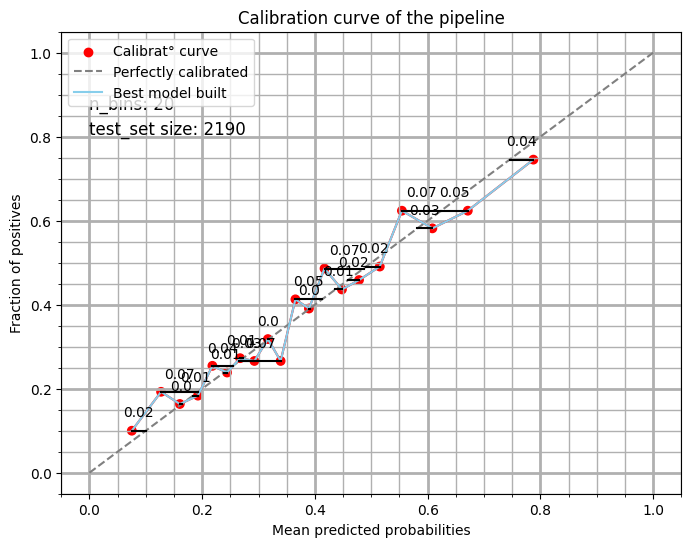

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.11]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.11, 0.15]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.15, 0.18]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.18, 0.21]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.21, 0.23]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.28]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.28, 0.3]    │                 

In [105]:
#src.pipeline.results

from sklearn.base import clone

from pipeline import results

# On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

# We print the results of GridSearchCV() execution
print(chosen_pipeline)
results.GridSearchCV_results(grid_search, X_train_00.copy())


# Plot Calibration curve for the pipeline build by GridSearchCV
test_seasons = [2021,2022,2023,2024]

# Make proba predictions retraining the pipeline at every Game Week or every Season on test_seasons:
proba_predicted_GW_training, Y_test_GW_training, X_info_test_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(chosen_pipeline), 'season', test_seasons)

#Plot Calibration curve of the pipeline and info about its bins
prob_pred_01, prob_true_01 = results.plot_calibration_curve_2(
                                Y_test_0 = Y_test_GW_training.copy(),
                                X_train_0 = X_info_test_GW_training.copy(),
                                proba_pred_0 = proba_predicted_GW_training.copy(),
                                n_bins_0 = 20,
                                strategy_0 = 'quantile',
                                color_0 = 'red',
                                GW_training_or_not = True,
                                )

#We display statistics on the pipeline probabilities deviation 
results.print_calibration_stats(prob_pred_01.copy(),
                                prob_true_01.copy(),
                                'non calibrated')


<span style="color:#FF1493;"> <strong> <font size="4">5) Pipeline and dataframes Saving


In [106]:
#src.pipeline.model
from pipeline import model
from features.features_selection import restricted_datasets



#On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_
chosen_pipeline_trained = chosen_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())

# Save the pipeline
model.save_pipeline(chosen_pipeline, "chosen_pipeline_trained")
model.save_pipeline(chosen_pipeline, "chosen_pipeline")


Successfully deleted the old pipeline:     chosen_pipeline_trained
Successfully saved the new pipeline:       chosen_pipeline_trained


Successfully deleted the old pipeline:     chosen_pipeline
Successfully saved the new pipeline:       chosen_pipeline


